In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import cmocean as ocCol
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from matplotlib.colors import ListedColormap

colours=sns.color_palette('colorblind', 10)
my_cmap = ListedColormap(colours)

color_list=colours

In [2]:
labels1=np.load('/home/maike/Documents/ECCO_BV/kMeans.npy')
labels2=np.load('/home/maike/Documents/ECCO_BV/kCluster6.npy')
labels3=np.load('/home/maike/Documents/ECCO_BV/clFromNAtl6.npy')
labels4=np.load('/home/maike/Documents/ECCO_BV/labels_withNoise.npy') # From the 'Uncovering North Atlantic regimes. There seem to be little clusters'
noiseMask=np.load('/home/maike/Documents/ECCO_BV/crazyResidualAsNaN.npy')

curl_BV = scipy.io.loadmat('/home/maike/Documents/ECCO_BV/baselineSverdrupRun.mat')

curlTOT=curl_BV['curlTOTUTEND'][:]
curlETAN=curl_BV['curlETAN'][:]
curlPH=curl_BV['curlPH'][:]
curlAdv=curl_BV['curlAdvec'][:]
curlAB=curl_BV['curlAB'][:]
curlExt=curl_BV['curlExt'][:]
curlDiss=curl_BV['curlDiss'][:]
curlVISrI=curl_BV['curlVISrI'][:]
curlCori=curl_BV['Um_Cori'][:]
curlBotDrag=curl_BV['UBotDrag'][:]

curlTau = curlExt + curlBotDrag*noiseMask
bpt = curlETAN + curlPH*noiseMask
curlA = (curlDiss-curlBotDrag)+curlVISrI*noiseMask
curlB = (curlAdv - curlCori) + curlAB*noiseMask
curlCori = curlCori*noiseMask
curlBV_residual= curlTOT-curlETAN-curlPH-curlAB-curlDiss-curlVISrI-curlAdv-curlExt*noiseMask

grid = scipy.io.loadmat('/home/maike/Documents/ECCO_BV/gridVars.mat')
land = grid['land'][:]
areaGlobal = grid['vortCellArea'][:]*noiseMask
lat=curl_BV['lat'][:]
lon=curl_BV['lon'][:]+180

grid = scipy.io.loadmat('/home/maike/Documents/ECCO_BV/H_wHFacC.mat')
H = grid['val']

prediction=np.load('/home/maike/Documents/NN_dynamicsPrediction/SteveData/SteveData_finalVersion.npy').reshape(384,320)

f =Dataset('/home/maike/Documents/NN_dynamicsPrediction/SteveData/climatologicalBV.nc')
Sresidual = f.variables['RESID'][0]
#curlTau = f.variables['curltau'][:]
ScurlB = f.variables['curlLU'][0]
ScurlA = f.variables['curlFH'][0]
Sbpt = f.variables['curlPK'][0]
ScurlTau = f.variables['curlFV'][0]
SbetaV = f.variables['betav'][0]

f =Dataset('/home/maike/Documents/NN_dynamicsPrediction/SteveData/annualMeanSSHandBathymetry.nc')
Slat_flat = f.variables['TLAT'][:]
Slon = f.variables['TLONG'][:]
SH = f.variables['HT'][:]
#SSum=BPT+curlA+betaV+curlTau+curlB

In [3]:
f =Dataset('/home/maike/Documents/NN_dynamicsPrediction/SteveData/climatologicalBV.nc')
Sresidual = f.variables['RESID']

In [4]:
#ind =getIndexesWithinRange(kMeanResultsScaled50, 0, 1)
maskedField = np.zeros(curlA.shape[:]); maskedField[:]=np.NaN
maskedField[:] = curlBV_residual[:]
maskedFieldForCrazyResiduals=np.zeros(curlA.shape[:]); maskedFieldForCrazyResiduals[:]=np.nan
indNotCrazy=np.where(np.logical_and(maskedField<=1e-12, maskedField>=-1e-12)) # Find the areas
#within the give range, that aren't crazy
maskedFieldForCrazyResiduals[indNotCrazy]=maskedField[indNotCrazy]

maskedFieldForCrazyResidualsTest=np.zeros(curlA.shape[:]); maskedFieldForCrazyResidualsTest[:]=np.NaN; maskedFieldForCrazyResidualsTest[indNotCrazy]=1
mask2=maskedFieldForCrazyResidualsTest*land

/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


In [7]:
latRoll = np.roll(lat, axis=1, shift=1)

lonRoll = np.roll(lon, axis=0, shift=1)

R=6373.0

c=((np.pi/180)**2)*R**2
sinLat = np.cos(lat*(np.pi/180))*(latRoll-lat)
Lon = lonRoll - lon
area = c*np.abs(sinLat)*np.abs(Lon)
#area = v*u
#area=(np.pi/180.)*(R**2 )*np.abs(lat) * np.abs(lon)
#plt.imshow(area)
#plt.clim(1e2,1e4)
#plt.colorbar()

In [11]:

def makeFig(data, Min, Max, step,title, ColMap, saveName):
    #plt.figure(figsize=(30,32))
    lons = lon[:,1]
    lats = lat[1,:]
    llons, llats = np.meshgrid(lons,lats)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0.05,0.05,0.9,0.9])
    m = Basemap(projection='kav7',lon_0=-145,resolution='l')
    im1 = m.contourf(llons,llats,(np.rot90(data,3)),np.arange(Min,Max, step),shading='flat',cmap=ColMap,latlon=True, color_codes=False)
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    cb = m.colorbar(im1,"right", size="5%", pad="9%")
    cb.ax.tick_params(labelsize=14) 
    cb.set_ticks([-0.5,0.5, 1.5, 2.5, 3.5, 4.5])
    #cb.set_ticklabels(["Depth coherent (43%)", "Interior flow (24.8%)", "quasi-Sverdrupian (14.6%)", "Vertical transformation (6.9%)", "Southern Ocean (1.9%)", "Non-linear (8.9%)"])
    #cb.set_ticklabels(["Momentum Dominated (MD 43%)", "Southward Sverdrupian (S-SV 24.8%)", "Northward Sverdrupian (N-SV 14.6%)", "Transitional (Trans 6.9%)", "Southern Ocean (SO 1.9%)", "Non-linear (Non-lin8.9%)"])
    #cb.set_ticklabels(["MD 43%", "S-SV 24.8%", "N-SV 14.6%", "TR 6.9%", "SO 1.9%", "NL 8.9%"])
    cb.set_ticklabels(["MD", "S-SV", "N-SV", "TR", "SO", "NL"]) 
    ax.set_title(title)
    #tick.label.set_fontsize(14) 
    yL=plt.gca().get_ylim()
    xL=plt.gca().get_xlim()
    #plt.text(xL[1]*0.01, yL[1]*0.1, label, fontsize=50, size=40, weight='bold', bbox={'facecolor':'white', 'alpha':0.7})
    plt.text(xL[1]*0.02, yL[1]*0.9, 'a', fontsize=50, size=30, weight='bold', bbox={'facecolor':'white', 'alpha':0.7})

    plt.savefig(saveName, format='png', dpi=500, bbox_inches='tight')
    plt.show()
    

    
def makeBarChartBVafterIndexes_maskedShelves_colourCoded(Area, indexes, tot, tau, cori, bpt, A, B, residual, saveName, title):
    """  """
    areaS = np.nansum(Area[indexes]) 
    curlTOT_box=np.nansum(tot[indexes])/areaS
    curlTau_box=np.nansum(tau[indexes])/areaS
    curlCori_box=np.nansum(cori[indexes])/areaS
    bpt_box=np.nansum(bpt[indexes])/areaS
    curlA_box=np.nansum(A[indexes])/areaS
    curlB_box=np.nansum(B[indexes])/areaS
    residual_box=np.nansum(residual[indexes])/areaS

    dataBars = np.asarray((curlTOT_box, curlTau_box, curlCori_box, bpt_box, 
                           curlA_box, curlB_box, residual_box))
    
    mask1 = dataBars < 0
    mask2 = dataBars >= 0
    
    N = 7
    ind = np.arange(N) # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind[mask1], dataBars[mask1], width, color='b') 
    rects1 = ax.bar(ind[mask2], dataBars[mask2], width, color='r')
    #plt.ylim(-1.6e-20, 1.6e-20)
    plt.title(title)
    labels=[r'$0$', r'$\nabla \times \tau_{s b}$', r'$\nabla \cdot (f \mathrm{U})$',
            r'$\frac{1}{\rho_0}\nabla\times (p_b \times\mathrm{H})$', r'$\nabla \times \mathrm{A}$', 
            r'$\nabla \times \mathrm{B}$', r'$\mathrm{Residual}$']

    plt.xticks( np.arange(N), labels, rotation=-45 )
    #plt.savefig(saveName, format='png', dpi=500, bbox_inches='tight') 
    print(dataBars)
    return dataBars[1:6]

def plotBarchartMapForClusters(data, cluster):
    inds = np.where(data==cluster)
    field=np.zeros(data.shape)*np.nan
    field[inds]=cluster
    areaCluster = np.nansum(area[inds])
    plt.imshow(field)
    makeBarChartBVafterIndexes_maskedShelves_colourCoded(inds, curlTOT, curlTau, curlCori, bpt, curlA, curlB, curlBV_residual, 
                                                         'kMeansBarChart_{:02d}.png'.format(cluster), '')
    makeFig(field, 1,50,1,'Area: {:.1f}%'.format(areaCluster), my_cmap, 'mapCluster_crazyResidualMasked_crazyResidualRemoved_5terms_{:02d}.png'.format(cluster))

def makeFigZoomBathymetry(data,cMin, cMax, cStep, title, saveName, llcrnrlon=-65, urcrnrlon=-20, llcrnrlat=35, urcrnrlat=65):
    fig = plt.figure(figsize=(10,10))
    map2 = Basemap(llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat, lon_0=-90, projection='merc', resolution='l')
    map2.drawmapboundary(fill_color='0.9')
    map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
    map2.drawcoastlines()
    map2.fillcontinents()
    map2.drawcountries()
    map2.drawparallels(np.arange(-90.,99.,5.),labels=[1,1,0,1], fontsize=15)
    map2.drawmeridians(np.arange(-180.,180.,20.),labels=[1,1,0,1], fontsize=15)
    lons = lon[:,1]
    lats = lat[1,:]
    llons, llats = np.meshgrid(lons,lats)
    im2=map2.contourf(llons,llats,data,np.arange(cMin, cMax, cStep),shading='flat',cmap=my_cmap,latlon=True)
   
    plt.title(title, fontsize=20)
    display(plt.gca().get_ylim())
    #cb = map2.colorbar(im2,"right", size="5%", pad="9%")
    cb = map2.colorbar(im2,"right", size="7%", pad="1%")
    cb.ax.tick_params(labelsize=20) 
    cb.set_ticks([-0.5,0.5, 1.5, 2.5, 3.5, 4.5])
    cb.set_ticklabels(["MD", "S-SV", "N-SV", "TR", "SO", "NL"])   
    im2=map2.contour(llons,llats,np.fliplr((np.roll(np.rot90(H,3),axis=1, shift=-360))), colors='k',latlon=True, levels=10)
    #plt.clabel(im2,fontsize=14,fmt='%1.1f', inline=1)
    yL=plt.gca().get_ylim()
    xL=plt.gca().get_xlim()
    plt.text(xL[1]*0.02, yL[1]*0.9, 'b', fontsize=50, size=30, weight='bold', bbox={'facecolor':'white', 'alpha':0.7})

    plt.savefig(saveName, format='png', dpi=100, bbox_inches='tight')

/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'shading', 'color_codes'
  if __name__ == '__main__':


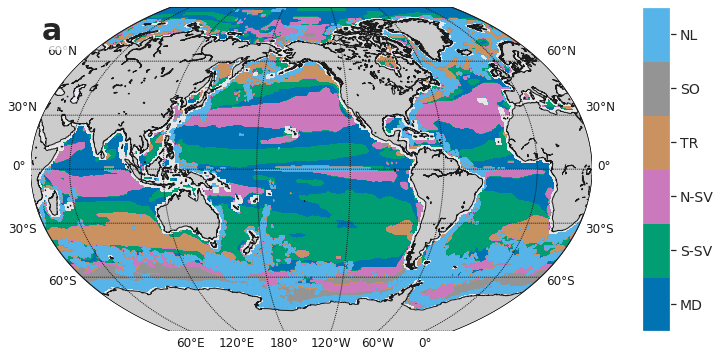

In [9]:
makeFig(np.flipud(np.roll(labels2*mask2,axis=0, shift=-360)), -1,6,1,'',my_cmap, 'originalClusters_newlabels.png')

/home/maike/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: The following kwargs were not used by contour: 'shading'


(0.0, 9938687.360683784)

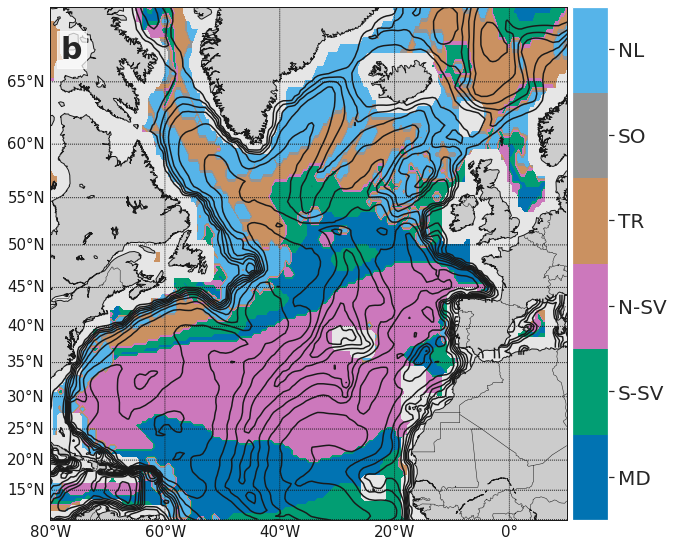

In [12]:
makeFigZoomBathymetry(np.fliplr(np.roll(np.rot90(labels2*mask2,3),axis=1, shift=-360)), -1,6,1,'', 'ECCO_NAtl.png', llcrnrlon=-80, urcrnrlon=10, llcrnrlat=10, urcrnrlat=70)

In [15]:

def plotBarchartReturnBars(data, cluster):
    inds = np.where(data==cluster)
    field=np.zeros(data.shape)*np.nan
    field[inds]=cluster
    A=np.zeros(data.shape)*np.nan
    A[inds]=curlA[inds]
    Bpt=np.zeros(data.shape)*np.nan
    Bpt[inds]=bpt[inds]
    areaCluster = np.nansum(areaGlobal[inds])*100/np.nansum(areaGlobal)
    if areaCluster<1: 
        print('Area too small')
    elif areaCluster>1:
        bars=makeBarChartBVafterIndexes_maskedShelves_colourCoded(area, inds, curlTOT*mask2, curlTau*mask2, curlCori*mask2, bpt*mask2, curlA*mask2, curlB*mask2, curlBV_residual*mask2, 'kMeansBarChart_crazyResidualMasked_crazyResidualRemoved_5terms_{:02d}.png'.format(cluster), '')
        #makeFig(field, 0, 7,1,'Area: {:.1f}%'.format(areaCluster), my_cmap, 'mapCluster_crazyResidualMasked_crazyResidualRemoved_5terms_{:02d}.png'.format(cluster))
        #makeFig(A, -1e-9, 1e-9, 0.1e-9, r'$\nabla\times\mathbf{A}$: Non linear terms', ocCol.cm.balance, 'testNonLin_{:02d}.png'.format(cluster))
        #makeFig(Bpt, -1e-9, 1e-9, 0.1e-9, r'$\frac{1}{\rho_0}\nabla\times(P_{b}\nabla H)$: Bottom pressure torque', ocCol.cm.balance, 'testNonLin_{:02d}.png'.format(cluster))
    return bars

0
[ 1.59617256e-18 -2.16627452e-15  3.98883271e-19  2.45565687e-15
 -5.29585226e-16  2.41380327e-16  1.98427298e-20]
[-2.16627452e-15  3.98883271e-19  2.45565687e-15 -5.29585226e-16
  2.41380327e-16]
1
[ 1.44448880e-18  1.04126410e-14 -8.48441872e-15 -1.60092452e-15
 -3.82878600e-16  5.70249678e-17  3.35606644e-22]
[ 1.04126410e-14 -8.48441872e-15 -1.60092452e-15 -3.82878600e-16
  5.70249678e-17]
2
[-3.59589181e-18 -1.65030826e-14  1.30865014e-14  4.97568458e-15
 -1.36749786e-15 -1.95211115e-16  9.76686720e-21]
[-1.65030826e-14  1.30865014e-14  4.97568458e-15 -1.36749786e-15
 -1.95211115e-16]
3
[-1.90693924e-17  4.72159160e-14 -2.91723788e-14 -1.86732318e-14
  3.27809174e-16  2.82875043e-16 -5.90912137e-20]
[ 4.72159160e-14 -2.91723788e-14 -1.86732318e-14  3.27809174e-16
  2.82875043e-16]
4
[-2.33671700e-17 -1.17804077e-13  6.07771584e-14  4.46373454e-14
  1.22962070e-14  6.99523490e-17  4.71031492e-20]
[-1.17804077e-13  6.07771584e-14  4.46373454e-14  1.22962070e-14
  6.99523490e-17]


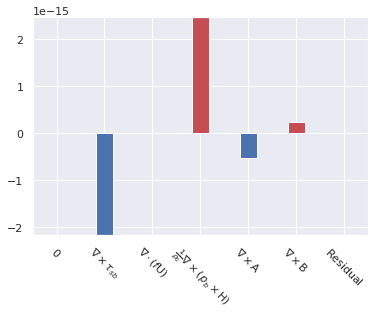

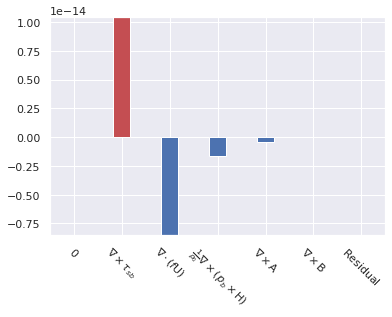

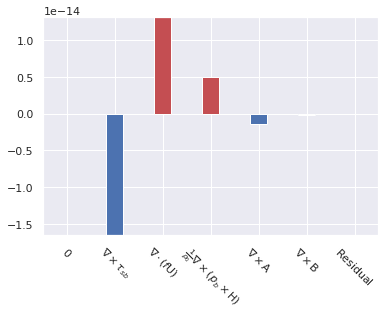

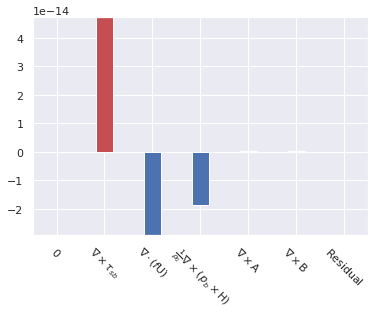

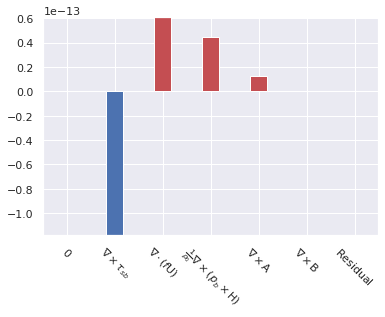

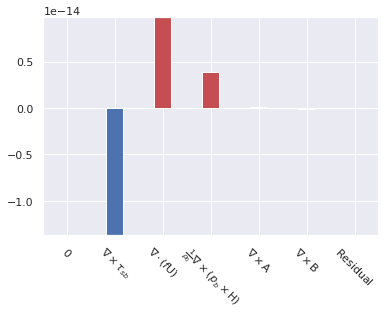

In [16]:
cl=6
bars=np.zeros((5,cl))
for nr in np.arange(0,cl): 
    print(nr)
    bars[:,nr]=plotBarchartReturnBars(labels2*mask2, nr)
    print(bars[:,nr])

Text(-0.35840000000000005, 6.999999999999999e-14, 'c')

<Figure size 360x5040 with 0 Axes>

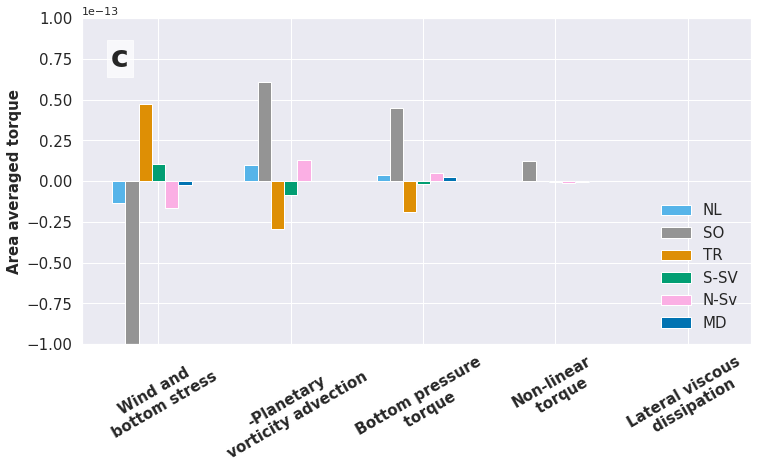

In [17]:
plt.figure(figsize=(5,70))

labels = [r'$\nabla \times \tau_{s b}$', r'$\nabla \cdot (f \mathrm{U})$',
            r'$\nabla p_B \times \nabla H$', r'$\nabla \times \mathrm{A}$', 
            r'$\nabla \times \mathrm{B}$']

#1) stress induced by wind at the surface and the sea floor, 
#2) the advection of planetary vorticity, 
#3) bathymetric interactions through bottom pressure torque, 
#4) nonlinear interactions between terms and 
#5) lateral viscous dissipation from within the ocean interior

labels = ['Wind and\n bottom stress', '-Planetary\n vorticity advection',
            'Bottom pressure\n torque', 'Non-linear\n torque', 
            'Lateral viscous\n dissipation']

men_means = bars[:,0]#[20, 34, 30, 35, 27]
w1_means = bars[:,2]#[25, 32, 34, 20, 25]
w2_means = bars[:,1]
w3_means = bars[:,3]
w4_means = bars[:,4]
w5_means = bars[:,5]


x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
w=width/2

fig, ax = plt.subplots(figsize=(12,6))
rects6 = ax.bar(x - w*6, w5_means, width, label='NL', color=color_list.as_hex()[9])
rects5 = ax.bar(x - w*4, w4_means, width, label='SO', color=color_list.as_hex()[7])
rects4 = ax.bar(x - w*2, w3_means, width, label='TR', color=color_list.as_hex()[1])
rects3 = ax.bar(x - w*0, w2_means, width, label='S-SV', color=color_list.as_hex()[2])
rects2 = ax.bar(x + w*2, w1_means, width, label='N-Sv', color=color_list.as_hex()[6])
rects1 = ax.bar(x + w*4, men_means, width, label='MD', color=color_list.as_hex()[0])


#rects7 = ax.bar(x + w*6, w6_means, width, label='Women')

ax.set_ylabel('Area averaged torque', fontsize=15, fontweight='bold')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, fontsize=15, fontweight='bold')
ax.tick_params(axis='y', which='major', labelsize=15)
ax.legend(loc=4, ncol=1, fontsize=15)
plt.ylim(-1e-13, 1e-13)
yL=plt.gca().get_ylim()
xL=plt.gca().get_xlim()
plt.text(xL[1]*-0.08, yL[1]*0.7, 'c', fontsize=20, size=30, weight='bold', bbox={'facecolor':'white', 'alpha':0.7})
#plt.savefig('ECCO_bars_wordLabels_c.png', format='png', dpi=100, bbox_inches='tight')

In [25]:
plt.figure(figsize=(10,30))
labels = [r'$\nabla \times \tau_{s b}$', r'$\nabla \cdot (f \mathrm{U})$',
            r'$\frac{1}{\rho_0}\nabla\times (p_b \times\mathrm{H})$', r'$\nabla \times \mathrm{A}$', 
            r'$\nabla \times \mathrm{B}$']
men_means = barsS[:,0]#[20, 34, 30, 35, 27]
w1_means = barsS[:,1]#[25, 32, 34, 20, 25]
w2_means = barsS[:,2]
w3_means = barsS[:,3]
w4_means = barsS[:,4]
w5_means = barsS[:,5]


x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars
w=width/2

fig, ax = plt.subplots()
rects6 = ax.bar(x - w*6, w5_means, width, label='NL', color=color_list.as_hex()[9])
rects5 = ax.bar(x - w*4, w4_means, width, label='SO', color=color_list.as_hex()[7])
rects4 = ax.bar(x - w*2, w3_means, width, label='Up', color=color_list.as_hex()[1])
rects3 = ax.bar(x - w*0, w2_means, width, label='Trans', color=color_list.as_hex()[2])
rects2 = ax.bar(x + w*2, w1_means, width, label='Sv', color=color_list.as_hex()[6])
rects1 = ax.bar(x + w*4, men_means, width, label='Mom', color=color_list.as_hex()[0])

ax.set_ylabel('Area averaged torque')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.legend(loc=4)
plt.ylim(-1e-13, 1e-13)
yL=plt.gca().get_ylim()
xL=plt.gca().get_xlim()
plt.text(xL[1]*0.52, yL[1]*0.62, 'CESM1 POP2', fontsize=20, size=20, weight='bold', bbox={'facecolor':'white', 'alpha':0.7})


Text(2.3296, 6.2e-14, 'CESM1 POP2')

<Figure size 720x2160 with 0 Axes>